In [1]:
from tqdm.auto import trange

import numpy as np
import plotly.graph_objects as go

import torch
from torch.utils.data import DataLoader

import os
import sys
import datetime

import matplotlib.pyplot as plt

from IPython.display import SVG, display

def imshow(fig):
    return display(SVG(fig.to_image(format="svg")))

%matplotlib inline
%config InlineBackend.figure_format='retina'

eps = 1e-10  # A negligible positive number
np.random.seed(0)


In [2]:
device = torch.device('cuda:0')
print("Device name: ", torch.cuda.get_device_name(0))
print("Number of CUDAs(cores): ", torch.cuda.device_count())


Device name:  NVIDIA GeForce RTX 2080 Ti
Number of CUDAs(cores):  8


In [3]:
%cd /tmp/pycharm_project_300
from src.data.data import TPPWrapper, pad_collate
from src.models.model import AutoIntTPPSameInfluence


/tmp/pycharm_project_300


In [5]:
def ReLU(x):
    return x * (x > 0)

def lamb_func(t, his_t):
    alpha = .2
    beta = .2
    mu = .2

    zeta = 1.
    c0 = -1.
    c1 = 1.
    c2 = 1.

    delta_t = t - his_t[his_t < t]
    dt0 = delta_t[0::2] # even index entries
    dt1 = delta_t[1::2] # even index entries

    lamb_t = mu + alpha * (np.sum(np.exp(-beta * dt0)) +
                           np.sum((c2 * dt1 ** 2 + c1 * dt1 + c0) * np.exp(-zeta * dt1)))
    lamb_t = ReLU(lamb_t)
    L = 2 / lamb_t

    count = delta_t[0::2]
    count = sum(count[count < 10])

    M = ReLU(mu + alpha * (np.sum(np.exp(-beta * dt0)) + count * 0.677))

    return (lamb_t, L, M)

dataset = TPPWrapper(lamb_func, n_sample=1, t_end=10000.0, max_lamb=100)
dataset.save('data/processed/alterHawkes')


  0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
"""
Plot λt vs. time at a specified location
"""

def plot_intensity(lamb_func, his_t, t_start=None, t_end=None, color='blue'):
    if t_start is None:
        t_start = np.min(his_t)
    if t_end is None:
        t_end = np.max(his_t)

    width, _ = plt.figaspect(.1)
    _, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(width, width / 2))

    # Plot the intensity
    x = np.arange(1001) / 1000
    x = eps + t_start + x * (t_end - t_start)
    y = [lamb_func(t, his_t)[0] for t in x]
    ax1.plot(x, y, color, label=f'λ(t)')
    ax1.set_xlim([t_start, t_end])
    ax1.legend()

    # Plot the events
    idx = np.logical_and(his_t >= t_start, his_t < t_end)
    x_ = np.zeros(np.sum(idx) + 2)
    x_[1:-1] = his_t[idx]
    x_[0] = t_start
    x_[-1] = t_end
    y_ = np.ones_like(x_)
    y_[0] = 0
    y_[-1] = 0

    ax2.stem(x_, y_,
             use_line_collection=True, label=f'Events')
    ax2.set_xlim([t_start, t_end])
    ax2.invert_yaxis()
    ax2.legend()

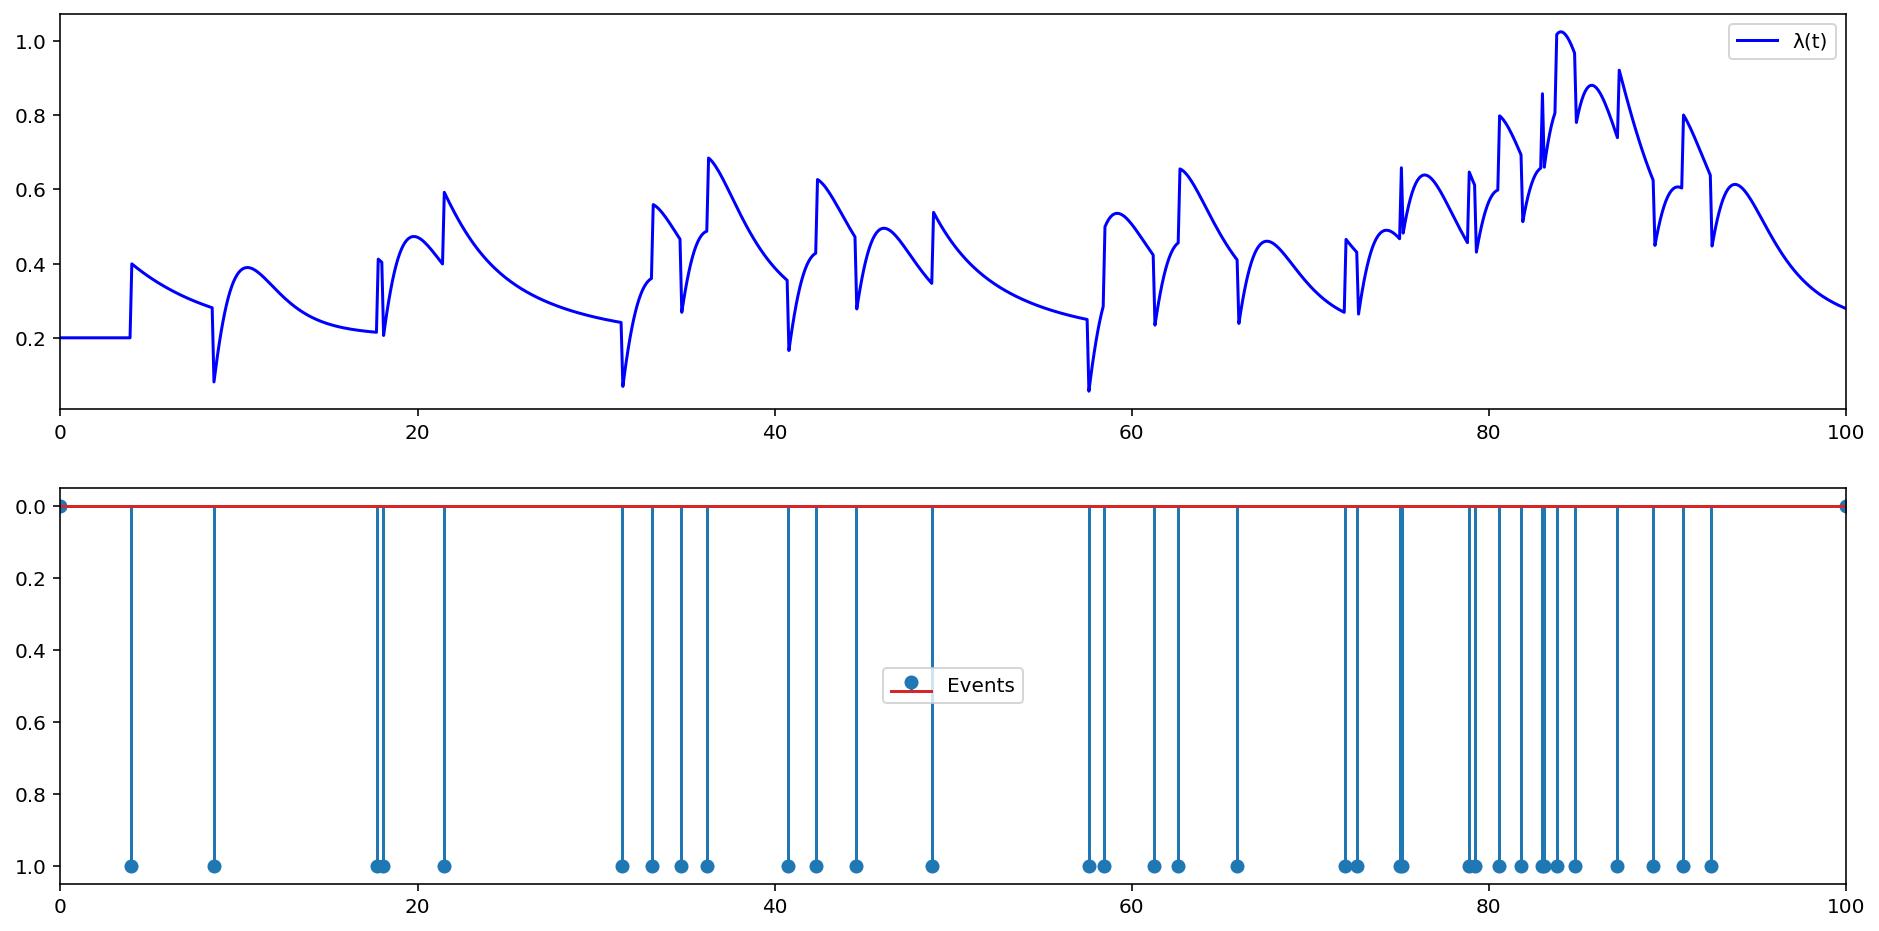

In [8]:
plot_intensity(lamb_func, dataset.seqs[0].numpy(), 0, 100)